<a href="https://colab.research.google.com/drive/157M15yLs2GvGlRcvq9USDAAZFB4S3HTm#scrollTo=QGzwcMR6Kg7M" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Dados do Campeonato Brasileiro 2023

## Introdução

Neste projeto, realizamos uma análise abrangente dos dados do Campeonato Brasileiro de 2023, rodada a rodada. O foco principal é a geração de relatórios detalhados para cada rodada do campeonato. Cada relatório inclui informações sobre os jogos realizados naquela rodada, como placar, Expected Goals (xG), Expected Goals sofridos (xGot), total de chutes e precisão dos chutes para os times visitantes e mandantes.

## Metodologia

1. **Coleta de Dados:** Utilizamos os dados reais do Campeonato Brasileiro 2023, fornecidos pela Opta via FutMob, incluindo informações sobre rodadas, times, jogadores, partidas, gols marcados, Expected Goals (xG), Expected Goals sofridos (xGot), total de chutes e precisão dos chutes.

2. **Processamento dos Dados:** Para cada rodada, processamos os dados para extrair as informações relevantes para cada jogo, incluindo placar, xG, xGot, Shots e Shots Accuracy para os times visitantes e mandantes.

3. **Geração de Relatórios de Rodada:** Com base nos dados processados, geramos um relatório detalhado para cada rodada do campeonato. Cada relatório inclui uma lista de jogos da rodada com as informações mencionadas acima para cada time participante.


In [2]:
#Importar as bibliotecas

import json
import re
import csv
from time import sleep
import time
import urllib
import os

from lxml import etree

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.patches as patches
from matplotlib import rcParams
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
from PIL import Image


import pprint

pd.set_option('display.max_columns', None)


In [3]:
r = 20  # Rodada
resultados = []
p = 0

In [4]:
#Carregamento dos Dados
new_df = pd.read_json('dados.json')
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   general        200 non-null    object
 1   header         200 non-null    object
 2   nav            200 non-null    object
 3   ongoing        200 non-null    bool  
 4   hasPendingVAR  200 non-null    bool  
 5   content        200 non-null    object
 6   seo            200 non-null    object
dtypes: bool(2), object(5)
memory usage: 8.3+ KB


In [5]:
# Renomear as colunas
new_df = new_df.rename(columns=lambda x: x.replace('.', '_'))

In [6]:
#Verificação do DataFrame
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   general        200 non-null    object
 1   header         200 non-null    object
 2   nav            200 non-null    object
 3   ongoing        200 non-null    bool  
 4   hasPendingVAR  200 non-null    bool  
 5   content        200 non-null    object
 6   seo            200 non-null    object
dtypes: bool(2), object(5)
memory usage: 8.3+ KB


## Dropar linhas e colunas desnecessárias

In [7]:
# Lista de chaves a serem removidas
chaves_remover = ['h2h', 'matchesInRound', 'poll', 'insights', 'topScorers', 'countryCode',
                  'QAData', 'liveticker', 'buzz', 'playoff', 'table', 'teams',
                  'tournamentNameForUrl', 'parentLeagueId', 'parentLeagueName',
                  'isCurrentSeason', 'parentLeagueSeason', 'countryCode']

# Percorrer todas as linhas do DataFrame
for index, row in new_df.iterrows():
    # Verificar se a coluna 'content' contém um dicionário
    if isinstance(row['content'], dict):
        # Remover as chaves da lista 'chaves_remover' do dicionário
        for chave in chaves_remover:
            if chave in row['content']:
                del row['content'][chave]

In [8]:
# Lista de colunas a serem removidas
colunas_remover = ['nav', 'ongoing', 'hasPendingVAR', 'general_teamColors_lightMode_home',
                   'general_teamColors_lightMode_away', 'general_teamColors_fontDarkMode_home',
                   'general_teamColors_fontDarkMode_away', 'general_teamColors_fontLightMode_home',
                   'general_teamColors_fontLightMode_away', 'general_started', 'general_finished',
                   'header_status_utcTime', 'header_status_finished', 'header_status_started',
                   'header_status_cancelled', 'header_status_reason_short', 'header_status_reason_shortKey',
                   'header_status_reason_long', 'header_status_reason_longKey',
                   'content_matchFacts_poll_oddspoll_Facts', 'content_matchFacts_poll_oddspoll_PollName',
                   'content_matchFacts_poll_oddspoll_MatchId', 'seo_faqJSONLD_mainEntity',
                   'seo_faqJSONLD_@type', 'seo_faqJSONLD_@context', 'seo_breadcrumbJSONLD',
                   'seo_eventJSONLD_performer', 'seo_eventJSONLD_offers_priceCurrency',
                   'seo_eventJSONLD_offers_price', 'seo_eventJSONLD_offers_availability',
                   'seo_eventJSONLD_offers_url', 'seo_eventJSONLD_offers_@type',
                   'seo_eventJSONLD_organizer_logo', 'seo_eventJSONLD_organizer_url',
                   'seo_eventJSONLD_organizer_name', 'seo_eventJSONLD_organizer_@type',
                   'seo_eventJSONLD_image', 'seo_eventJSONLD_location_url',
                   'seo_eventJSONLD_location_@type', 'seo_eventJSONLD_eventAttendanceMode',
                   'seo_eventJSONLD_eventStatus', 'seo_eventJSONLD_endDate', 'seo_eventJSONLD_startDate',
                   'seo_eventJSONLD_description', 'seo_eventJSONLD_name', 'seo_eventJSONLD_awayTeam_url',
                   'seo_eventJSONLD_awayTeam_logo', 'seo_eventJSONLD_awayTeam_sport',
                   'seo_eventJSONLD_awayTeam_name', 'seo_eventJSONLD_awayTeam_@type',
                   'seo_eventJSONLD_awayTeam_@context', 'seo_eventJSONLD_homeTeam_url',
                   'seo_eventJSONLD_homeTeam_logo', 'seo_eventJSONLD_homeTeam_sport',
                   'seo_eventJSONLD_homeTeam_name', 'seo_eventJSONLD_homeTeam_@type',
                   'seo_eventJSONLD_homeTeam_@context', 'seo_eventJSONLD_sport', 'seo_eventJSONLD_@type',
                   'seo_eventJSONLD_@context', 'seo_path', 'content_matchFacts_momentum_main_debugTitle']

# Iterar em todas as linhas do DataFrame
for index, row in new_df.iterrows():
    # Remover as colunas da lista 'colunas_remover'
    new_df.loc[index, colunas_remover] = pd.NA

# Remover as colunas com valores NA
new_df = new_df.dropna(axis=1, how='all')



## Criar o banco de dados

In [9]:
j = r * 10 # Multiplica a quantidade de jogos pelo numero de rodadas
# Criar uma lista vazia para armazenar os dados de cada rodada
dados_por_rodada = []

# Iterar por cada rodada
for rodada in range(j):
    try:
    # Obter os dados da rodada atual
        dados_rodada = rodada
    
        # Extrair os dados específicos da rodada
        acc                         = new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][5]['stats']
        acc2                        = new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][3]['stats'][5]['stats']
        acc3                        = new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][3]['stats'][6]['stats']
        jogo                        = new_df.general[dados_rodada]['matchId']
        dia_jogo                    = pd.to_datetime(new_df.general[dados_rodada]['matchTimeUTC'])
        rodada_info                 = new_df.content[dados_rodada]['matchFacts']['infoBox']['Tournament']['leagueName']
        rodada                      = int(new_df.content[dados_rodada]['matchFacts']['infoBox']['Tournament']['round'])
        torneio                     = new_df.general[dados_rodada]['parentLeagueName']
        temporada                   = new_df.general[dados_rodada]['parentLeagueSeason']
        time_casa                   = new_df.general[dados_rodada]['homeTeam']['name']
        time_fora                   = new_df.general[dados_rodada]['awayTeam']['name']
        id_time_casa                = int(new_df.general[dados_rodada]['homeTeam']['id'])
        id_time_fora                = int(new_df.general[dados_rodada]['awayTeam']['id'])
        logo_casa                   = new_df.header[dados_rodada]['teams'][0]['imageUrl']
        logo_fora                   = new_df.header[dados_rodada]['teams'][1]['imageUrl']
        gols_casa                   = int(new_df.header[dados_rodada]['teams'][0]['score'])
        gols_fora                   = int(new_df.header[dados_rodada]['teams'][1]['score'])
        placar                      = new_df.header[dados_rodada]['status']['scoreStr']
        melhor_jogador              = new_df.content[dados_rodada]['matchFacts']['playerOfTheMatch']['name']['fullName']
        time_melhor_jogador         = new_df.content[dados_rodada]['matchFacts']['playerOfTheMatch']['teamName']
        id_time_melhor_jogador      = int(new_df.content[rodada]['matchFacts']['playerOfTheMatch']['teamId'])
        id_melhor_jogador           = int(new_df.content[dados_rodada]['matchFacts']['playerOfTheMatch']['id'])
        nota                        = float(new_df.content[dados_rodada]['matchFacts']['playerOfTheMatch']['rating']['num'])
        min_jogados_melhor_jogador  = int(new_df.content[dados_rodada]['matchFacts']['playerOfTheMatch']['minutesPlayed'])
        estadio                     = new_df.content[dados_rodada]['matchFacts']['infoBox']['Stadium']['name']
        cidade                      = new_df.content[dados_rodada]['matchFacts']['infoBox']['Stadium']['city']
        lat                         = new_df.content[dados_rodada]['matchFacts']['infoBox']['Stadium']['lat']
        lon                         = new_df.content[dados_rodada]['matchFacts']['infoBox']['Stadium']['long']
        juiz                        = new_df.content[dados_rodada]['matchFacts']['infoBox']['Referee']['text']
        pais_juiz                   = new_df.content[dados_rodada]['matchFacts']['infoBox']['Referee']['country']
        img_juiz                    = new_df.content[dados_rodada]['matchFacts']['infoBox']['Referee'].get('imgUrl')
        momentos                    = new_df.content[dados_rodada]['momentum'] if isinstance(new_df.content[0]['momentum'], list) else None
        xG_casa                     = float(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][2]['stats'][1]['stats'][0])
        xG_fora                     = float(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][1]['stats'][1])
        xGOT_casa                   = float(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][2]['stats'][4]['stats'][0])
        xGOT_fora                   = float(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][2]['stats'][4]['stats'][1])
        shotsOT_casa                = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][1]['stats'][3]['stats'][0])
        shotsOT_fora                = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][1]['stats'][3]['stats'][1])
        posse_casa                  = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][0]['stats'][0])
        posse_fora                  = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][0]['stats'][1])
        chute_casa                  = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][2]['stats'][0])
        chute_fora                  = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][2]['stats'][1])
        chance_casa                 = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][3]['stats'][0])
        chance_fora                 = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][3]['stats'][1])
        fora_casa                   = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][4]['stats'][0])
        fora_fora                   = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][4]['stats'][1])
        precisao_passes_casa        = int(re.findall(r'\d+', acc[0])[0])
        precisao_passes_fora        = int(re.findall(r'\d+', acc[1])[0])
        precisao_bola_longa_casa    = int(re.findall(r'\d+', acc2[0])[0])
        precisao_bola_longa_fora    = int(re.findall(r'\d+', acc2[1])[0])
        precisao_cruzamento_casa    = int(re.findall(r'\d+', acc3[0])[0])
        precisao_cruzamento_fora    = int(re.findall(r'\d+', acc3[1])[0])
        passes_casa                 = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][3]['stats'][1]['stats'][0])
        passes_fora                 = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][3]['stats'][1]['stats'][1])
        faltas_casa                 = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][6]['stats'][0])
        faltas_fora                 = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][6]['stats'][1])
        impedimentos_casa           = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][7]['stats'][0])
        impedimentos_fora           = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][7]['stats'][1])
        escanteios_casa             = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][8]['stats'][0])
        escanteios_fora             = int(new_df.content[dados_rodada]['stats']['Periods']['All']['stats'][0]['stats'][8]['stats'][1])

        # Criar um dicionário com os dados da rodada atual
        dados = {
            'Rodada': rodada,
            'Jogo': jogo,
            'Dia_Jogo': dia_jogo,
            'Rodada_Info': rodada_info,
            'Torneio': torneio,
            'Temporada': temporada,
            'Time_Casa': time_casa,
            'Time_Fora': time_fora,
            'ID_Time_Casa': id_time_casa,
            'ID_Time_Fora': id_time_fora,
            'Logo_Casa': logo_casa,
            'Logo_Fora': logo_fora,
            'Gols_Casa': gols_casa,
            'Gols_Fora': gols_fora,
            'Placar': placar,
            'Melhor_Jogador': melhor_jogador,
            'Time_Melhor_Jogador': time_melhor_jogador,
            'ID_Time_Melhor_Jogador': id_time_melhor_jogador,
            'ID_Melhor_Jogador': id_melhor_jogador,
            'Nota': nota,
            'Min_Jogados_Melhor_Jogador': min_jogados_melhor_jogador,
            'Estadio': estadio,
            'Cidade': cidade,
            'Lat': lat,
            'Lon': lon,
            'Juiz': juiz,
            'Pais_Juiz': pais_juiz,
            'Img_Juiz': img_juiz,
            'Momentos': momentos,
            'xG_Casa': xG_casa,
            'xG_Fora': xG_fora,
            'xGOT_Casa': xGOT_casa,
            'xGOT_Fora': xGOT_fora,
            'ShotsOT_Casa': shotsOT_casa,
            'ShotsOT_Fora': shotsOT_fora,
            'Posse_Casa': posse_casa,
            'Posse_Fora': posse_fora,
            'Chute_Casa': chute_casa,
            'Chute_Fora': chute_fora,
            'Chance_Casa': chance_casa,
            'Chance_Fora': chance_fora,
            'Fora_Casa': fora_casa,
            'Fora_Fora': fora_fora,
            'Precisao_Passes_Casa': precisao_passes_casa,
            'Precisao_Passes_Fora': precisao_passes_fora,
            'Precisao_Bola_Longa_Casa': precisao_bola_longa_casa,
            'Precisao_Bola_Longa_Fora': precisao_bola_longa_fora,
            'Precisao_Cruzamento_Casa': precisao_cruzamento_casa,
            'Precisao_Cruzamento_Fora': precisao_cruzamento_fora,
            'Passes_Casa': passes_casa,
            'Passes_Fora': passes_fora,
            'Faltas_Casa': faltas_casa,
            'Faltas_Fora': faltas_fora,
            'Impedimentos_Casa': impedimentos_casa,
            'Impedimentos_Fora': impedimentos_fora,
            'Escanteios_Casa': escanteios_casa,
            'Escanteios_Fora': escanteios_fora
        }
        
        # Adicionar os dados da rodada à lista
        dados_por_rodada.append(dados)

    except Exception as e:
        # If an exception occurs (missing data or any other error), handle it gracefully
        print(f"Error occurred in processing rodada {rodada}: {e}")
        # You can also set default values for missing data if desired
        dados = {
            'Rodada': rodada,
            'Jogo': None,
            'Dia_Jogo': None,  
        }
        dados_por_rodada.append(dados)

    # Criar o DataFrame com todos os dados
    df_final = pd.DataFrame(dados_por_rodada)

# Exibir o DataFrame
print(df_final)


Error occurred in processing rodada 128: 'NoneType' object is not subscriptable
Error occurred in processing rodada 130: 'NoneType' object is not subscriptable
     Rodada     Jogo                  Dia_Jogo Rodada_Info  Torneio Temporada  \
0         1  4123624 2023-04-15 21:30:00+00:00     Serie A  Serie A      2023   
1         1  4123618 2023-04-15 21:30:00+00:00     Serie A  Serie A      2023   
2         1  4123625 2023-04-15 21:30:00+00:00     Serie A  Serie A      2023   
3         1  4123621 2023-04-15 21:30:00+00:00     Serie A  Serie A      2023   
4         1  4123622 2023-04-16 00:00:00+00:00     Serie A  Serie A      2023   
..      ...      ...                       ...         ...      ...       ...   
195       3  4123670 2023-04-30 00:00:00+00:00     Serie A  Serie A      2023   
196       3  4123610 2023-04-30 19:00:00+00:00     Serie A  Serie A      2023   
197       3  4123655 2023-04-30 21:30:00+00:00     Serie A  Serie A      2023   
198       3  4123658 2023-04-3

In [10]:
total_jogos = len(new_df.content)

jogo = 0
todos_os_dicionarios = []

while jogo < total_jogos:
    tamanho = len(new_df.content[jogo]['shotmap']['shots'])
    eventos = []
    jogo_id = new_df.content[jogo]['matchFacts']['matchId']  # Obter o ID do jogo
    print(f'jogo {jogo_id} tem {tamanho} entradas')
    for i in range(tamanho):
        evento = new_df.content[jogo]['shotmap']['shots'][i]
        evento['matchId'] = jogo_id  # Adicionar o ID do jogo ao dicionário do evento
        eventos.append(evento)

    todos_os_dicionarios.extend(eventos)

    jogo += 1

df_resultado = pd.DataFrame(todos_os_dicionarios)

jogo 4123624 tem 27 entradas
jogo 4123618 tem 28 entradas
jogo 4123625 tem 35 entradas
jogo 4123621 tem 22 entradas
jogo 4123622 tem 33 entradas
jogo 4123660 tem 19 entradas
jogo 4123654 tem 31 entradas
jogo 4123667 tem 25 entradas
jogo 4123669 tem 24 entradas
jogo 4123668 tem 26 entradas
jogo 4123652 tem 22 entradas
jogo 4123653 tem 31 entradas
jogo 4123659 tem 33 entradas
jogo 4123661 tem 32 entradas
jogo 4123651 tem 37 entradas
jogo 4123620 tem 20 entradas
jogo 4123617 tem 25 entradas
jogo 4123623 tem 33 entradas
jogo 4123649 tem 26 entradas
jogo 4123662 tem 30 entradas
jogo 4123663 tem 31 entradas
jogo 4123635 tem 15 entradas
jogo 4123666 tem 37 entradas
jogo 4123650 tem 38 entradas
jogo 4123664 tem 31 entradas
jogo 4123637 tem 17 entradas
jogo 4123665 tem 28 entradas
jogo 4123636 tem 29 entradas
jogo 4123648 tem 34 entradas
jogo 4123634 tem 20 entradas
jogo 4123632 tem 30 entradas
jogo 4123629 tem 20 entradas
jogo 4123631 tem 14 entradas
jogo 4123638 tem 31 entradas
jogo 4123633 t

## Estrutura do codigo por rodada

In [74]:
#Rodada da Viz
rod = 20

In [75]:
# Filtrando por rodada
rodada1 = df_final[df_final['Rodada']==rod]

In [76]:
r1_week = pd.DataFrame(columns=['time_casa', 'id_time_casa', 'gols_casa', 'xG_casa', 'xGOT_casa',
                                'chute_casa', 'shotsOT_casa', 'time_fora', 'id_time_fora',
                                'gols_fora', 'xG_fora', 'xGOT_fora', 'chute_fora', 'shotsOT_fora', 'dia_jogo'])

for index, row in rodada1.iterrows():
    r1_week.loc[index] = [row['Time_Casa'],
                          row['ID_Time_Casa'],
                          row['Gols_Casa'],
                          row['xG_Casa'],
                          row['xGOT_Casa'],
                          row['Chute_Casa'],
                          row['ShotsOT_Casa'],
                          row['Time_Fora'],
                          row['ID_Time_Fora'],
                          row['Gols_Fora'],
                          row['xG_Fora'],
                          row['xGOT_Fora'],
                          row['Chute_Fora'],
                          row['ShotsOT_Fora'],
                          row['Dia_Jogo']]

In [21]:
#Verificando
r1_week.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 88 to 97
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   time_casa     10 non-null     object             
 1   id_time_casa  10 non-null     float64            
 2   gols_casa     10 non-null     float64            
 3   xG_casa       10 non-null     float64            
 4   xGOT_casa     10 non-null     float64            
 5   chute_casa    10 non-null     float64            
 6   shotsOT_casa  10 non-null     float64            
 7   time_fora     10 non-null     object             
 8   id_time_fora  10 non-null     float64            
 9   gols_fora     10 non-null     float64            
 10  xG_fora       10 non-null     float64            
 11  xGOT_fora     10 non-null     float64            
 12  chute_fora    10 non-null     float64            
 13  shotsOT_fora  10 non-null     float64            
 14  dia_jogo      10

# FONTES

In [77]:
font_path = r"fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "otf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

rcParams['font.family'] = 'Karla'

Adicionando cores
Definimos um novo mapa de cores para adicionar o gradiente à coluna de precisão.

In [16]:
colors = [
    '#efe9e6',
    '#e9e1dd',
    '#e3dad3',
    '#dcd3c9',
    '#d4ccc0',
    '#ccc6b7',
    '#c3bfae',
    '#bab9a6',
    '#b0b39e',
    '#a6ad96',
    '#9ba790',
    '#90a18a',
    '#849b84',
    '#789680',
    '#6c907c',
    '#608a79',
    '#538476',
    '#467e74',
    '#387872',
    '#287271',
]
soc_cm = LinearSegmentedColormap.from_list('SOC', colors, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

C:\Users\leojo\AppData\Local\Temp\ipykernel_16960\405490639.py:24: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  cm.register_cmap(name='SOC', cmap=soc_cm)


C:\Users\leojo\AppData\Local\Temp\ipykernel_16960\3565774524.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('SOC')


'plt.savefig(\n\tf"brasileirao_{rod}_rodada_tr.png",\n\tdpi = 600,\n\tfacecolor = "none",\n\tbbox_inches="tight",\n    edgecolor="none",\n\ttransparent = True\n)'

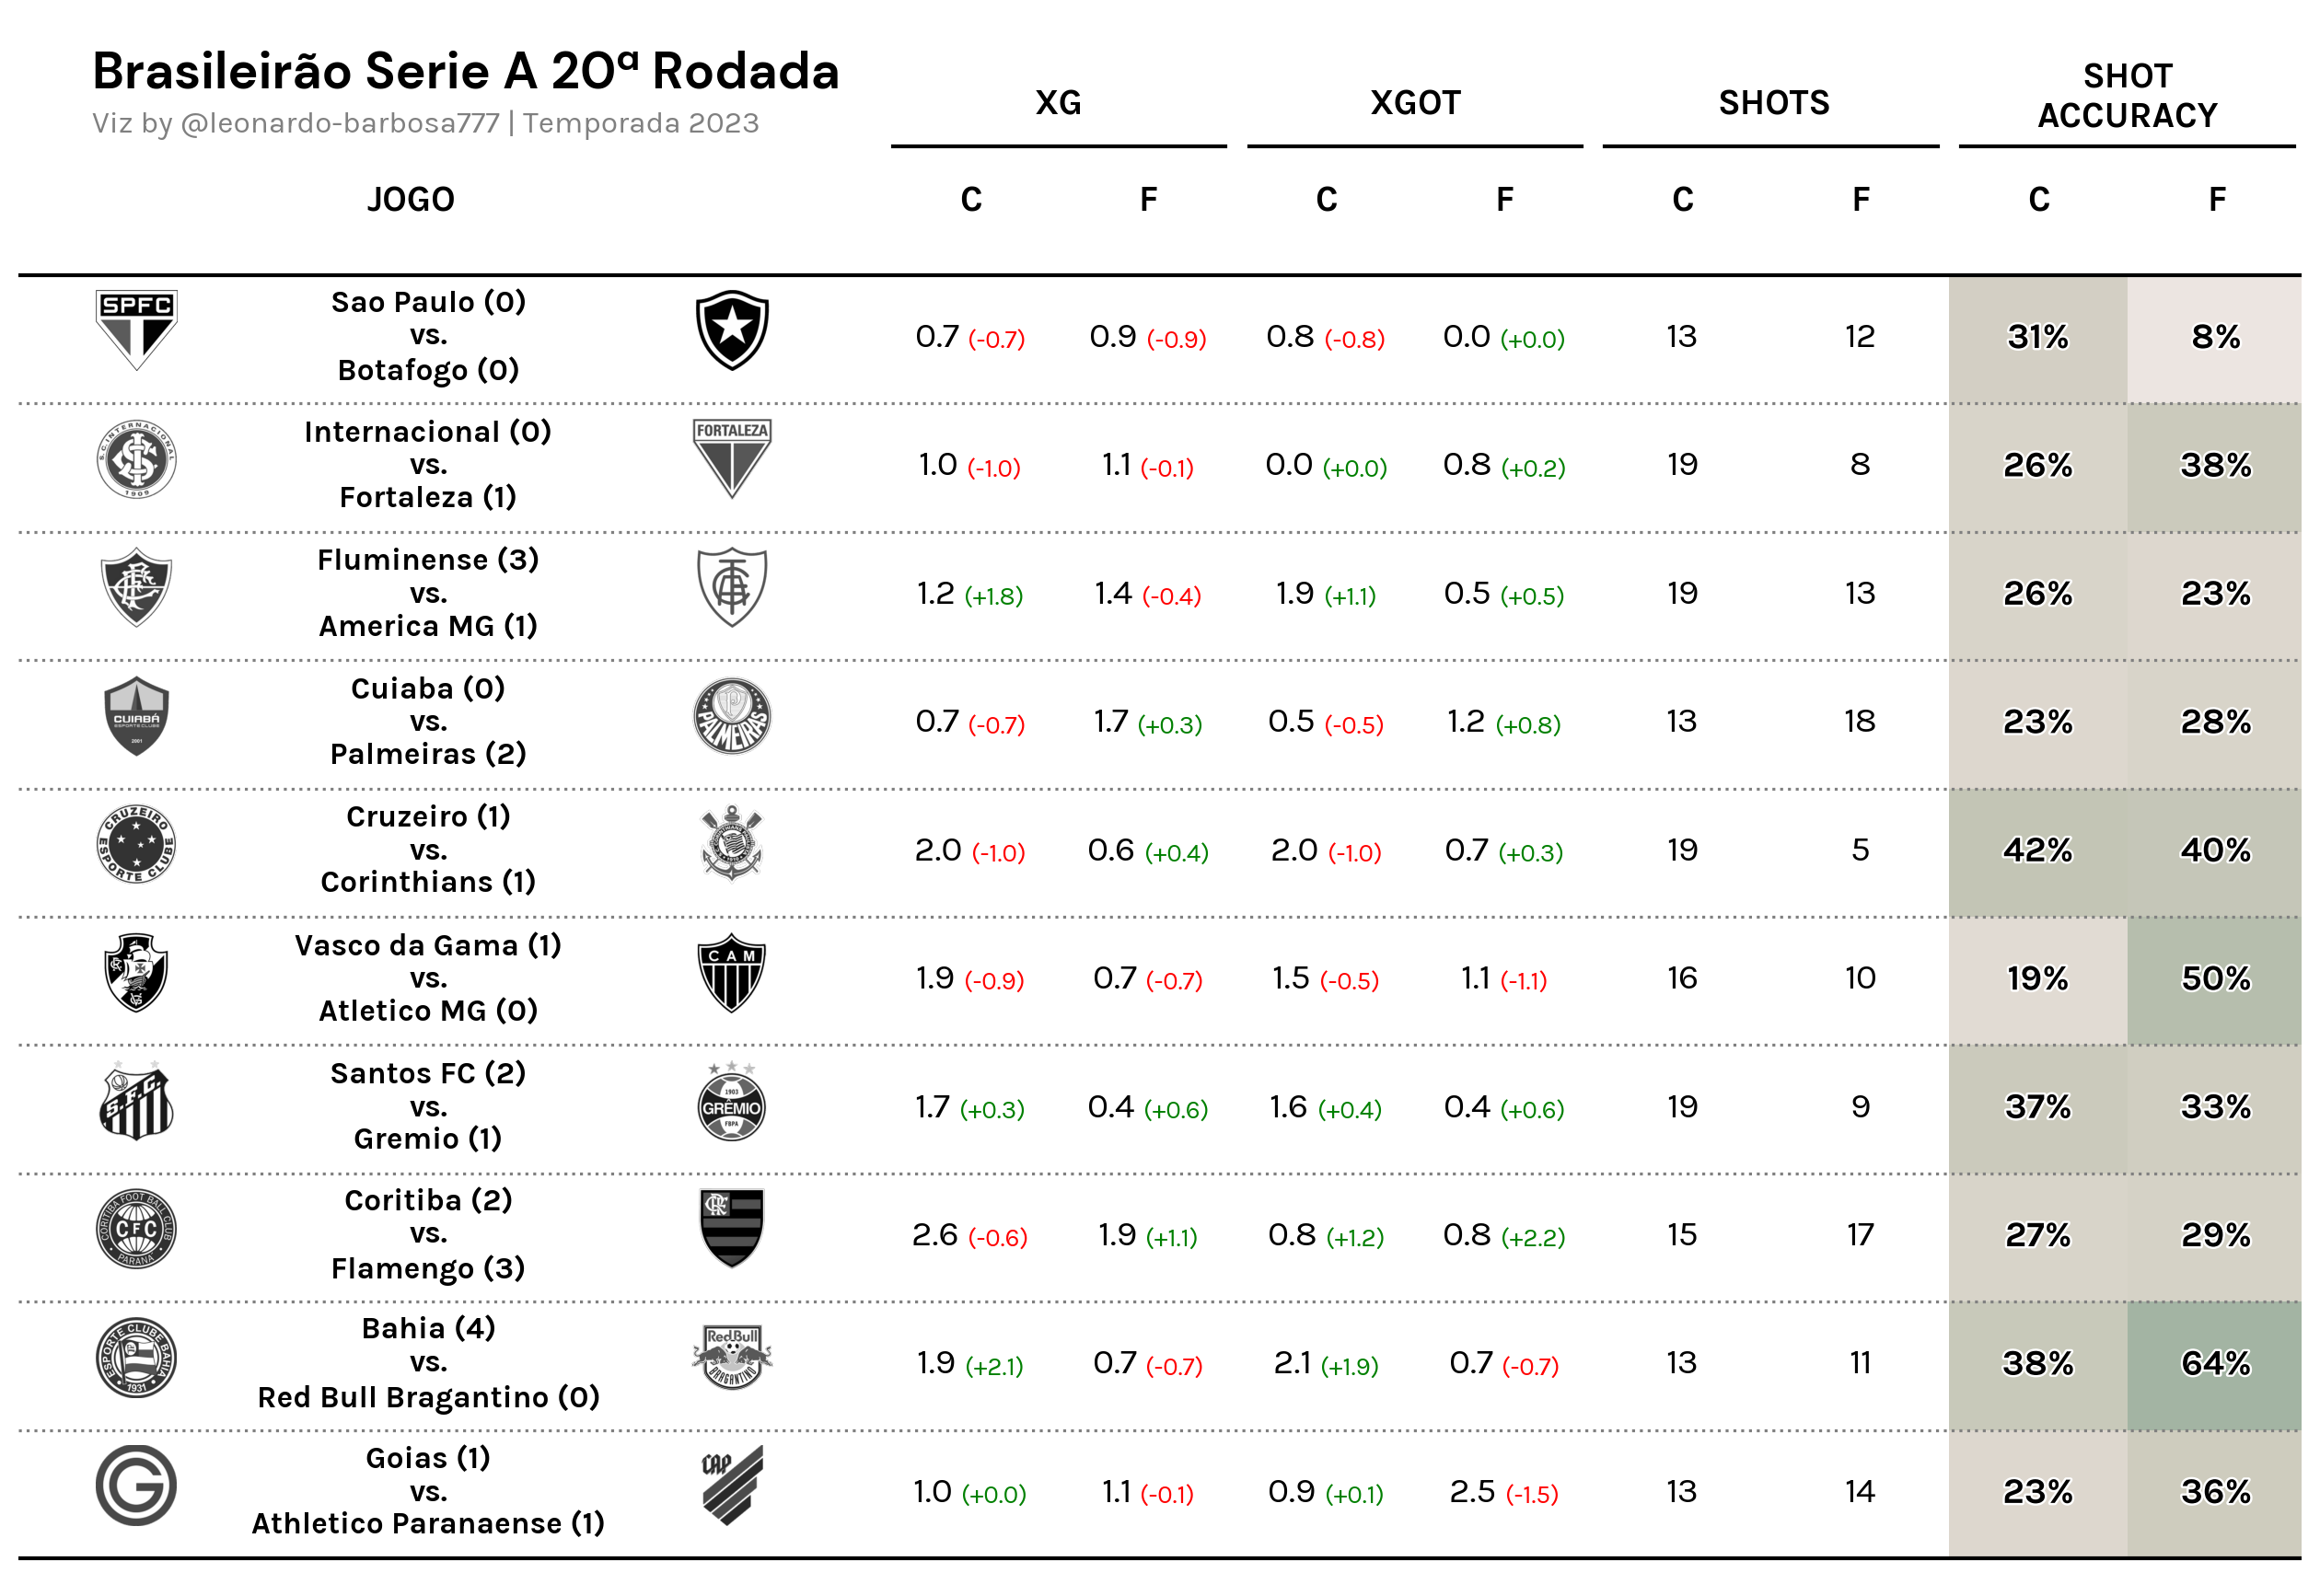

In [80]:
# Criando a figura e o subplot
fig = plt.figure(figsize=(16, 11), dpi = 200)
ax = plt.subplot(111, facecolor = "#EFE9E6")
# Definindo o número de colunas e linhas do gráfico com base no DataFrame r1_week

ncols = 14 
nrows = r1_week.shape[0]

# Ordenando o DataFrame 'dia_jogo' em ordem decrescente e redefinindo os índices
r1_week = r1_week.sort_values(by='dia_jogo', ascending=False).reset_index(drop=True)

ax.set_xlim(0, ncols + .75)
ax.set_ylim(-.15, nrows + 2)

# Definindo a URL para os logotipos das equipes de futebol e 
# funções auxiliares para adicionar os logotipos ao gráfico 

fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# Native data to normalized data coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

# -- O CMAP é usado para o gradiente
cmap = cm.get_cmap('SOC')
# Iterando sobre as linhas do DataFrame r1_week para criar o gráfico
for y in range(nrows):
    # -----------------------------------------
    # - Casa logo
    x = 0
    team_id = r1_week['id_time_casa'].iloc[y]
    ax_coords = DC_to_NFC([x + .5, y + .25])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.04, 0.04], anchor = "W")
    club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")
    # -----------------------------------------
    # - Fixture result
    x = 2.65
    home_name = r1_week['time_casa'].iloc[y]
    away_name = r1_week['time_fora'].iloc[y]
    home_score = r1_week['gols_casa'].iloc[y]
    away_score = r1_week['gols_fora'].iloc[y]
    label_ = f'{home_name} ({home_score:.0f})\nvs.\n{away_name} ({away_score:.0f})'
    ax.annotate(
        xy=(x,y + 0.5),
        text=label_,
        ha='center',
        va='center',
        size=12,
        weight='bold'
    )
    # -----------------------------------------
    # - Fora logo
    x = 5 
    team_id = r1_week['id_time_fora'].iloc[y]
    ax_coords = DC_to_NFC([x - .65, y + .25])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.04, 0.04], anchor = "W")
    club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")
    # -----------------------------------------
    # -- xGs
    home_xG = r1_week['xG_casa'].iloc[y]
    away_xG = r1_week['xG_fora'].iloc[y]
    xG_diff_h = home_score - home_xG
    xG_diff_a = away_score - away_xG
    # -- Casa xG
    x = 6.15
    if xG_diff_h < 0:
        high_color='red'
        label_h_ = f'{home_xG:.1f} <({(xG_diff_h):.1f})>'
    else:
        high_color='green'
        label_h_ = f'{home_xG:.1f} <(+{(xG_diff_h):.1f})>'
    ax_text(
        x=x,y=y+0.5,
        s=label_h_,
        ha='center',
        va='center',
        highlight_textprops=[{'size':10,'color':high_color}],
        size=14,
        ax=ax
    )
    # -- Fora xG
    x = 7.3
    if xG_diff_a < 0:
        high_color='red'
        label_a_ = f'{away_xG:.1f} <({(xG_diff_a):.1f})>'
    else:
        high_color='green'
        label_a_ = f'{away_xG:.1f} <(+{(xG_diff_a):.1f})>'
    ax_text(
        x=x,y=y+0.5,
        s=label_a_,
        ha='center',
        va='center',
        highlight_textprops=[{'size':10,'color':high_color}],
        size=14,
        ax=ax
    )
    # -----------------------------------------
    # -- xGOT
    home_xGOT = r1_week['xGOT_casa'].iloc[y]
    away_xGOT = r1_week['xGOT_fora'].iloc[y]
    xGOT_diff_h = home_score - home_xGOT
    xGOT_diff_a = away_score - away_xGOT
    # -- Casa xGOT
    x = 8.45
    if xGOT_diff_h < 0:
        high_color='red'
        label_h_ = f'{home_xGOT:.1f} <({(xGOT_diff_h):.1f})>'
    else:
        high_color='green'
        label_h_ = f'{home_xGOT:.1f} <(+{(xGOT_diff_h):.1f})>'
    ax_text(
        x=x,y=y+0.5,
        s=label_h_,
        ha='center',
        va='center',
        highlight_textprops=[{'size':10,'color':high_color}],
        size=14,
        ax=ax
    )
    # -- Fora xGOT
    x = 9.6
    if xGOT_diff_a < 0:
        high_color='red'
        label_a_ = f'{away_xGOT:.1f} <({(xGOT_diff_a):.1f})>'
    else:
        high_color='green'
        label_a_ = f'{away_xGOT:.1f} <(+{(xGOT_diff_a):.1f})>'
    ax_text(
        x=x,y=y+0.5,
        s=label_a_,
        ha='center',
        va='center',
        highlight_textprops=[{'size':10,'color':high_color}],
        size=14,
        ax=ax
    )
    # -----------------------------------------
    # -- Chutes
    home_shots = r1_week['chute_casa'].iloc[y]
    away_shots = r1_week['chute_fora'].iloc[y]
    label_h_ = f'{home_shots:.0f}'
    label_a_ = f'{away_shots:.0f}'
    # -- Casa shots
    x = 10.75
    ax_text(
        x=x,y=y+0.5,
        s=label_h_,
        ha='center',
        va='center',
        size=14,
        ax=ax
    )
    # -- Fora shots
    x = 11.9
    ax_text(
        x=x,y=y+0.5,
        s=label_a_,
        ha='center',
        va='center',
        size=14,
        ax=ax
    )
    # -- Precisão
    home_shotsOT = r1_week['shotsOT_casa'].iloc[y]
    away_shotsOT = r1_week['shotsOT_fora'].iloc[y]
    label_h_ = f'{home_shotsOT/home_shots:.0%}'
    label_a_ = f'{away_shotsOT/away_shots:.0%}'
    # -- Casa shots
    x = 13.05
    text_ = ax.annotate(
        xy=(x,y+0.5),
        text=label_h_,
        ha='center',
        va='center',
        size=14,
        weight='bold'
    )
    text_.set_path_effects(
        [path_effects.Stroke(linewidth=1.75, foreground="white"), path_effects.Normal()]
    )
    # -- Fora shots
    x = 14.2
    text_ = ax.annotate(
        xy=(x,y+0.5),
        text=label_a_,
        ha='center',
        va='center',
        size=14,
        weight='bold'
    )
    text_.set_path_effects(
        [path_effects.Stroke(linewidth=1.75, foreground="white"), path_effects.Normal()]
    )
    # -----------------------------------------
    # -- Adcionando as cores
    # -- Subtraímos e adicionamos .575 porque a largura da nossa coluna é 1.15, 1/15/2 = .575
    x = 13.05
    ax.fill_between(
        x=[(x - .575), (x + .575)],
        y1=y,
        y2=y + 1,
        color=cmap(home_shotsOT/home_shots),
        zorder=2,
        ec="None",
        alpha=0.75
    )
    x = 14.2
    ax.fill_between(
        x=[(x - .575), (x + .575)],
        y1=y,
        y2=y + 1,
        color=cmap(away_shotsOT/away_shots),
        zorder=2,
        ec="None",
        alpha=0.75
    )


# ----------------------------------------------------------------
# Bordas da Tabela
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw = 1.5, color = 'black', marker = '', zorder = 4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw = 1.5, color = 'black', marker = '', zorder = 4)
for x in range(nrows):
    if x == 0:
        continue
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw = 1.15, color = 'gray', ls = ':', zorder = 3 , marker = '')

# ----------------------------------------------------------------
# - Titulos das Colunas
ax.annotate(
    xy = (2.25, nrows + .5),
    text = "JOGO",
    weight = "bold",
    ha = "left",
    size = 14
)
title_positions = [6.15 + 1.15*i for i in range(0,8)]
title_labels = ['C' if i % 2 == 0 else 'F' for i in range(0,8)]
for index in range(0,8):
    ax.annotate(
        xy = (title_positions[index], nrows + .5),
        text = title_labels[index],
        weight = "bold",
        ha = "center",
        size = 14
    )
    # --- Linhas para deixar mais bonito o visual
    if index % 2 != 0:
        continue
    ax.plot(
        [title_positions[index] - .5, title_positions[index + 1] + .5],
        [nrows + 1, nrows + 1],
        lw = 1.5,
        color = 'black'
    )

ax.annotate(
    xy = ((6.15 + 7.3)/2, nrows + 1.25),
    text = 'XG',
    weight = "bold",
    ha = "center",
    size = 14
)
ax.annotate(
    xy = ((8.45 + 9.6)/2, nrows + 1.25),
    text = 'XGOT',
    weight = "bold",
    ha = "center",
    size = 14
)
ax.annotate(
    xy = ((10.785 + 11.9)/2, nrows + 1.25),
    text = 'SHOTS',
    weight = "bold",
    ha = "center",
    size = 14
)
ax.annotate(
    xy = ((13.05 + 14.2)/2, nrows + 1.15),
    text = 'SHOT\nACCURACY',
    weight = "bold",
    ha = "center",
    size = 14
)

ax.set_axis_off()

fig_text(
    x = 0.15, y = 0.84, 
    s = f"Brasileirão Serie A {rod}ª Rodada",
    va = "bottom", ha = "left",
    fontsize = 20, color = "black", font = "DM Sans", weight = "bold"
)

fig_text(
    x = 0.15, y = 0.82, 
    s = "Viz by @leonardo-barbosa777 | Temporada 2023",
    va = "bottom", ha = "left",
    fontsize = 12, color = "gray", font = "Karla"
)

plt.savefig(
	"brasileirao_18_rodada.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

"""plt.savefig(
	f"brasileirao_{rod}_rodada_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)"""